<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/Computer_vision_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practicing Basic Computer vision topics

# Edge detection using Linear diffusion filter : using Laplacian kernal
### Idea = rate of change of concentration at any point = Laplacian of image intensity at a pixel, which is done by second derivative of image intensity along x and y axis. --> shows rapid intensity changes

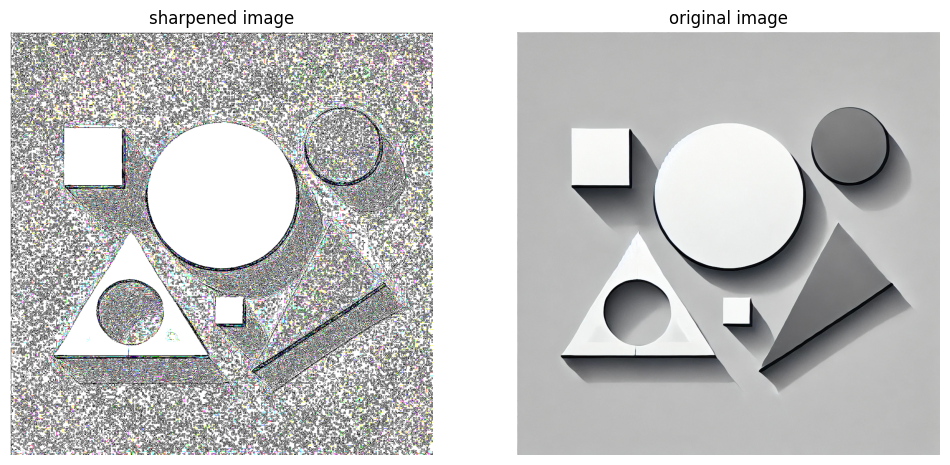

In [3]:
from scipy.ndimage import convolve
import numpy as np
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

up_image_path = '/content/IMG_123.png'
img = Image.open(up_image_path)



img_array = np.array(img)

def linear_diffusion(img_array, alpha):
    laplace_kernel = np.array([[1,4,1],
                       [4,-20,4],
                       [1,4,1],
                       ])*(1/6)
    lapla_img = np.zeros_like(img_array)
    for c in range(3):
        # adding this laplacian back to the original image enhances the edges
        lapla_img[:, :, c] = convolve(img_array[:,:,c], laplace_kernel, mode='reflect')
    # sharpen the image by adding the laplacian to the original image
    sharpened_img = img_array - alpha * lapla_img
        #print("convolution is hapening")
    sharpened_img = np.clip(sharpened_img, 0,255)
    return sharpened_img

diffused_arry = linear_diffusion(img_array, alpha =0.9)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("sharpened image")
plt.imshow(diffused_arry)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("original image")
plt.imshow(img_array)
plt.axis('off')

plt.show()


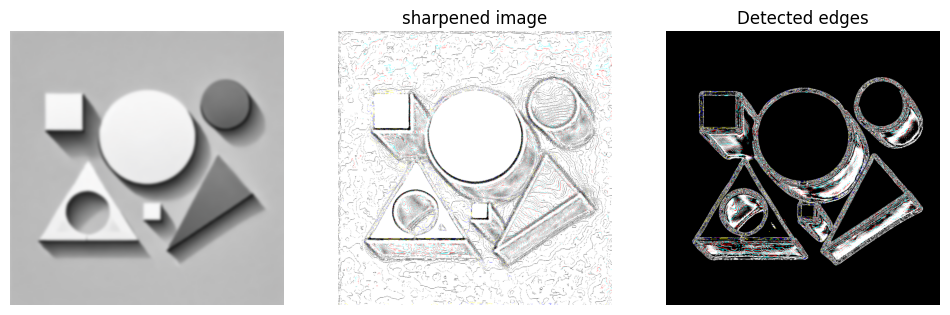

In [23]:
# First Derivative Edge detection
import scipy.ndimage as ndimage
from scipy.ndimage import sobel

def guassian_blur(image , sigma= 1):
    return ndimage.gaussian_filter(image , sigma=sigma)

sigma = 5 # variance
image = img_array
blurred_img = guassian_blur(image , sigma=sigma) # blur the image reduce noise and high frequency components(avoid aliasing)

def compute_gradient_magnitude(image):
    dx = np.zeros_like(image)
    dy = np.zeros_like(image)
    for c in range(image.shape[2]):
        dx[:,:,c] = sobel(image[:,:,c], axis = 0) # along x direction
        dy[:,:,c] = sobel(image[:, :, c], axis = 1) # along y direction
    # Compute the magnitude of the gradient
    mag = np.sqrt(dx**2 + dy**2)
    return mag

def apply_threshold(mag, threshold = 50):
    # Apply a threshold to gradient maginture, then multiply by 255 for pixel values
    return (mag > threshold).astype(np.float32) *255

threshold = 11
gradient_mag = compute_gradient_magnitude(blurred_img)
edges = apply_threshold(gradient_mag, threshold=threshold)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(blurred_img)
plt.axis('off')

diffused_arry = linear_diffusion(blurred_img, alpha = .9)
plt.subplot(1,3,2)
plt.title("sharpened image")
plt.imshow(diffused_arry)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(edges, cmap='gray')
plt.title("Detected edges")
plt.axis('off')

plt.show()
#print(gradient_mag)

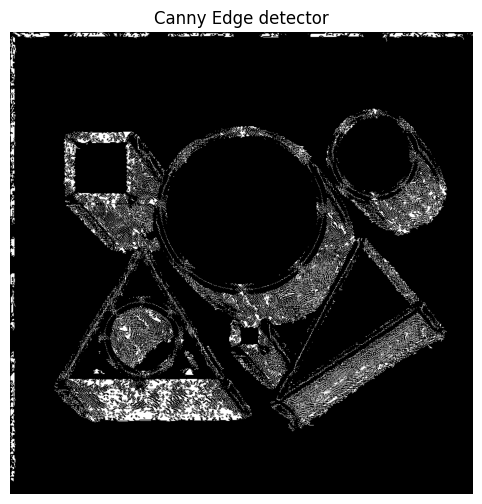

In [33]:
# Canny Edge detection
import scipy.ndimage as ndimage
from scipy.ndimage import sobel

def guassian_blur(image , sigma= 1):
    return ndimage.gaussian_filter(image , sigma=sigma)


def compute_gradient_magnitude(image):
    # Ensure the image is grayscale
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Convert to grayscale
    # Calculate gradients using Sobel operator
    dx = sobel(image, axis=0)  # Horizontal gradient
    dy = sobel(image, axis=1)  # Vertical gradient
    magnitude = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)  # Gradient direction in radians
    return magnitude, angle

def non_max_suppression(magnitude, angle):
    M, N = magnitude.shape
    Z = np.zeros((M, N), dtype=np.float32)
    angle = np.rad2deg(angle) % 180  # Normalize angles to fall between 0-180

    for i in range(1, M-1):
        for j in range(1, N-1):
            # Find neighbors in the gradient direction
            q = 255
            r = 255
            # Determine neighbors based on the angle
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] < 180):
                q = magnitude[i, j+1] # get the vertical neighbours value for horizontal gradient
                r = magnitude[i, j-1]
            elif (22.5 <= angle[i, j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            elif (67.5 <= angle[i, j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            elif (112.5 <= angle[i, j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if magnitude[i, j] >= q and magnitude[i, j] >= r: # compare with gradient of neighbours
                Z[i, j] = magnitude[i, j]
            else:
                Z[i, j] = 0

    return Z

def threshold(mag,high_threshold, low_threshold):
    high_thresh = np.max(mag) * high_threshold # percentage of maximum gradient -> higher threshold
    low_thresh = high_thresh * low_threshold
    strong = np.float32(255)
    weak = np.float32(25)

    strong_i, strong_j = np.where(mag >= high_thresh)
    weak_i, weak_j = np.where((mag < high_thresh) & (mag >= low_thresh))

    result = np.zeros(mag.shape, dtype=np.float32)
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak
    return result, weak, strong

def hysteresis(image, weak, strong):
    M, N = image.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if image[i, j] == weak:
                if np.max(image[i-1:i+2, j-1:j+2]) == strong:
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image


sigma = 5 # variance
image = img_array
low_threshold = 0.05
high_threshold = 0.25
blurred_img = guassian_blur(image , sigma=sigma) # blur the image reduce noise and high frequency components(avoid aliasing)

#threshold = 11
gradient_mag , gradient_angle = compute_gradient_magnitude(blurred_img)
suppressed_edges = non_max_suppression(gradient_mag, gradient_angle)
threshold_edges , weak , strong = threshold(suppressed_edges, low_threshold, high_threshold)
final_edges = hysteresis(threshold_edges, weak=25, strong=255)

plt.figure(figsize=(12,6))

plt.imshow(final_edges, cmap='gray')
plt.title("Canny Edge detector")
plt.axis('off')

plt.show()


In [ ]:
 import numpy as np
 A = np.array([[0,0,0,0,0],
               [0,0,0,0,0],
               [5,5,0,0,0],
               [5,5,0,0,0],
               [5,5,0,0,0]])
 C =[]
 D = []
 J = []
 B = A[1:4,1:4]
 for i in range(4):
    for j in range(4):
        if i > 0 and j>0:
            c = (A[i, j+1] - A[i,j-1])/2
            #print(f"fx[{j},{i}] = (A[{i}, {j+1}]- A[{i},{j-1}])/2 = {c}")
            d = (A[i+1,j] - A[i-1,j])/2
            #print(f" fy[{j},{i}] = ( A[{i+1},{j}] - A[{i-1},{j}])/2 = {d}")
            print(f"J[{j},{i}] = [{c**2} , {c*d}],[{c*d}, {d**2}]")
            C.append(c)
            D.append(d)
            #print(f"i is {i} and j is {j}")
print(C)
print(D)

J[1,1] = [0.0 , 0.0],[0.0, 6.25]
J[2,1] = [0.0 , 0.0],[0.0, 0.0]
J[3,1] = [0.0 , 0.0],[0.0, 0.0]
J[1,2] = [6.25 , -6.25],[-6.25, 6.25]
J[2,2] = [6.25 , -0.0],[-0.0, 0.0]
J[3,2] = [0.0 , 0.0],[0.0, 0.0]
J[1,3] = [6.25 , -0.0],[-0.0, 0.0]
J[2,3] = [6.25 , -0.0],[-0.0, 0.0]
J[3,3] = [0.0 , 0.0],[0.0, 0.0]
[0.0, 0.0, 0.0, -2.5, -2.5, 0.0, -2.5, -2.5, 0.0]
[2.5, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0]
